In [1]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:13<00:00, 38.2MB/s]
100% 1.21G/1.21G [00:13<00:00, 94.2MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_or

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

In [3]:
%ls

Data/                                         gtzan-dataset-music-genre-classification.zip
electro-disco-fashion-30-sec-edit-198117.wav  sample_data/
fairiesx27-disco-145381.mp3


In [4]:
import zipfile
with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [5]:
# Getting Genres from folder name

MUSIC = '/content/Data/genres_original'
music_dataset = [] # File locations for each wav file
genre_target = [] #
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/content/Data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[4])


In [6]:
# Displaying genres

print(set(genre_target))

{'hiphop', 'country', 'disco', 'classical', 'blues', 'pop', 'jazz', 'rock', 'reggae', 'metal'}


In [7]:
audio_path = music_dataset[500]
# img_path = './data/images_original/blues/blues00011.png'
x , sr = librosa.load(audio_path)



librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

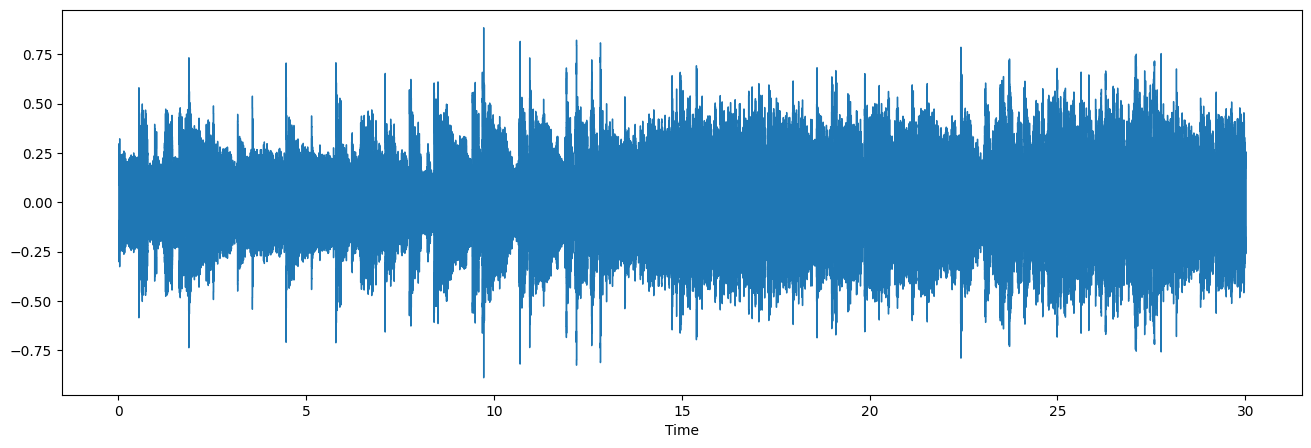

In [8]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
librosa.display.waveshow(x, sr=sr)

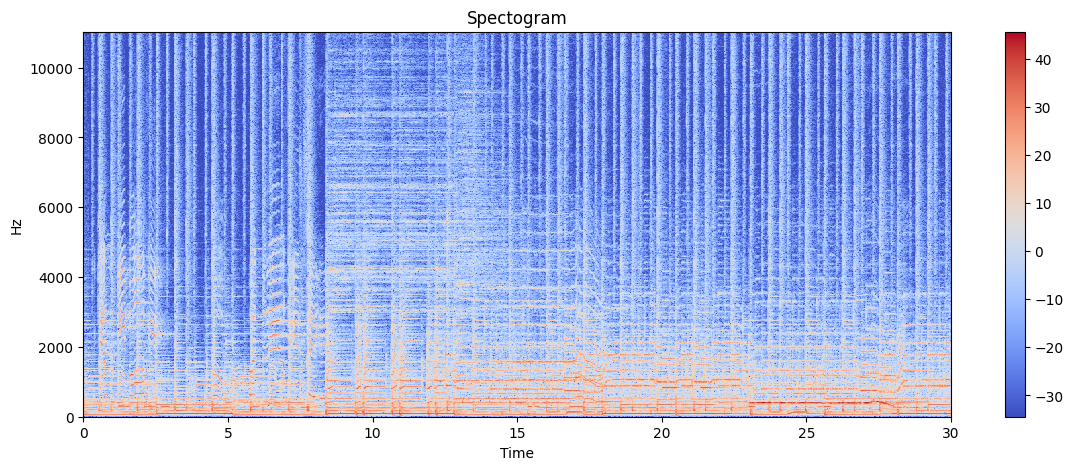

In [9]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

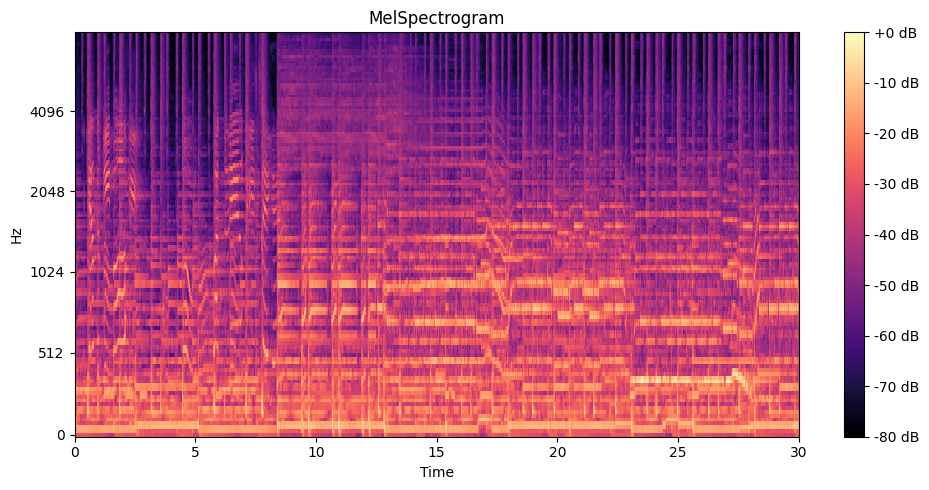

In [10]:
# Visualizing Audio as Mel-Spectogram

file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

In [11]:
DATASET_PATH = '/content/Data/genres_original'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


In [12]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)

                if file_path != '../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)


                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        # Extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [13]:
corrupt_file = '/content/Data/genres_original/jazz/jazz.00054.wav'
if os.path.exists(corrupt_file):
    os.remove(corrupt_file)


In [14]:
# Runs Data Processing
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/content/Data/genres_original/country/country.00070.wav, segment:2
/content/Data/genres_original/country/country.00070.wav, segment:3
/content/Data/genres_original/country/country.00070.wav, segment:4
/content/Data/genres_original/country/country.00070.wav, segment:5
/content/Data/genres_original/country/country.00070.wav, segment:6
/content/Data/genres_original/country/country.00045.wav, segment:1
/content/Data/genres_original/country/country.00045.wav, segment:2
/content/Data/genres_original/country/country.00045.wav, segment:3
/content/Data/genres_original/country/country.00045.wav, segment:4
/content/Data/genres_original/country/country.00045.wav, segment:5
/content/Data/genres_original/country/country.00045.wav, segment:6
/content/Data/genres_original/country/country.00078.wav, segment:1
/content/Data/genres_original/country/country.00078.wav, segment:2
/content/Data/genres_original/country/country.00078.wav, segment:3
/content/Da

In [15]:
DATA_PATH = "./data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    :return z : Mappings for data
    """

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 214, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 107, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 107, 6, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 105, 4, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 53, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 832)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,042 (265.79 KB)

 Trainable params: 67,850 (265.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.1300 - loss: 2.9539 - val_accuracy: 0.2514 - val_loss: 2.0678
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3155 - loss: 1.9958 - val_accuracy: 0.4105 - val_loss: 1.6288
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3889 - loss: 1.6850 - val_accuracy: 0.4616 - val_loss: 1.4629
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4537 - loss: 1.5250 - val_accuracy: 0.4939 - val_loss: 1.3571
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4993 - loss: 1.3836 - val_accuracy: 0.5350 - val_loss: 1.2744
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5188 - loss: 1.3425 - val_accuracy: 0.5328 - val_loss: 1.2508
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5493 - loss: 1.2567 - val_accuracy: 0.5606 - val_loss: 1.2143
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5625 - loss: 1.2339 - val_accuracy: 

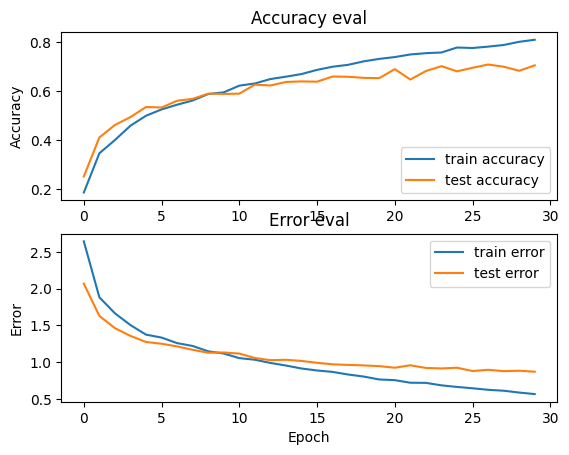

47/47 - 1s - 27ms/step - accuracy: 0.6856 - loss: 0.9165

Test accuracy: 0.6855807900428772


In [16]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [17]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
Target: hiphop, Predicted label: ['hiphop']


In [18]:
model.save('music_gnere.h5')

# Now Checking to the Song From Random Source

## upload file to Colab

In [19]:
file_name = "/content/electro-disco-fashion-30-sec-edit-198117.wav"

## Preprocess Audio

In [20]:
import librosa
import numpy as np

# Load the audio file
file_path = file_name
signal, sample_rate = librosa.load(file_path, sr=22050)

# Extract MFCC features
mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)

# Ensure that the MFCC has the correct number of timesteps (216)
if mfcc.shape[1] > 216:
    mfcc = mfcc[:, :216]
elif mfcc.shape[1] < 216:
    mfcc = np.pad(mfcc, ((0, 0), (0, 216 - mfcc.shape[1])), mode='constant')

# Reshape to match the input shape (216, 13, 1)
mfcc = mfcc.T  # Transpose to have (216, 13)
mfcc = mfcc[..., np.newaxis]  # Add the channel dimension

# Final shape should be (216, 13, 1)
print("MFCC shape for prediction:", mfcc.shape)

# Add a batch dimension (1 sample)
mfcc = np.expand_dims(mfcc, axis=0)

# Make the prediction
predicted_label = model.predict(mfcc)
print("Predicted label:", np.argmax(predicted_label))
predicted_index = np.argmax(predicted_label)
# print(genre_target[])
print(predicted_index)


MFCC shape for prediction: (216, 13, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted label: 4
4


In [21]:
list(set(genre_target))

['hiphop',
 'country',
 'disco',
 'classical',
 'blues',
 'pop',
 'jazz',
 'rock',
 'reggae',
 'metal']

In [22]:
set(genre_target)

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

In [23]:
predicted_label

array([[1.0525901e-04, 3.4279379e-04, 3.2086378e-01, 1.0682731e-02,
        5.9269494e-01, 3.7521876e-02, 8.2213059e-04, 1.2589098e-03,
        2.0805897e-02, 1.4901656e-02]], dtype=float32)

In [24]:
set(genre_target)

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

In [25]:
import numpy as np
import librosa

def preprocess_audio(file_path, sample_rate=22050):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=sample_rate)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)

    # Ensure the MFCC array has the correct number of timesteps (216)
    if mfcc.shape[1] < 216:
        # Pad or truncate the MFCC array if needed
        padding = 216 - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode='constant', constant_values=0)
    elif mfcc.shape[1] > 216:
        mfcc = mfcc[:, :216]

    # Transpose the MFCC array to match the expected input shape
    mfcc = mfcc.T  # Transpose to shape (216, 13)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

    return mfcc


In [27]:
def predict(model, X):
    """Predict a sample using the trained model.
    :param model: Trained classifier
    :param X: Input data
    """
    # Perform prediction
    prediction = model.predict(X)

    # Get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    # Mapping from index to label
    # Ensure `z` is a list or dictionary that maps indices to genre labels
    predicted_label = z[predicted_index[0]]

    print("Predicted label:", predicted_label)


In [28]:
file_path = '/content/electro-disco-fashion-30-sec-edit-198117.wav'
mfcc_new = preprocess_audio(file_path)

# Check the shape
print("MFCC new shape:", mfcc_new.shape)  # Should be (1, 216, 13, 1)

# Predict the genre
predict(model, mfcc_new)


MFCC new shape: (1, 216, 13, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label: pop
